In [1]:
import sys
import yaml
from typing import Tuple
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np

from api.util import get_prediction_matrix, get_coordinate_list, f1_score, l2_norm, f1_l2_combined_loss, gauss_single_image
from api.util_image import next_multiple_
import tensorflow as tf
import skimage.io
import skimage.util
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
model = tf.keras.models.load_model('../models/model_pia_spots_1589820239.h5', {'l2_norm': l2_norm, 'f1_l2_combined_loss': f1_l2_combined_loss, 'f1_score': f1_score})

In [3]:
def predict_crop(
    crop: np.ndarray, model: tf.keras.models.Model, localisator: str = "Network localisation"
) -> np.ndarray:
    """Predict on a crop of size needed for the network and return coordinates."""
    model_input_size = model.layers[0].output_shape[0][1]
    model_output_size = model.layers[-1].output_shape[1]

    if crop.shape[0] != model_input_size:
        raise ValueError(
            f"Model need input of shape [{model_input_size},{model_input_size}], image has shape {crop.shape}"
        )
    assert crop.shape[0] == crop.shape[1]

    model_cell_size = model_input_size / model.layers[-1].output_shape[1]

    pred = model.predict(crop[None, ..., None]).squeeze()

    if localisator == "Gauss localisation":
        print("Using gauss 2D fitting for localisation!")
        pred = gauss_single_image(crop[..., None], pred, model_cell_size, model_cell_size).squeeze()

    coord = get_coordinate_list(pred, model_input_size, model_output_size)
    return coord[..., 0], coord[..., 1]


def predict_baseline(
    image: np.ndarray, model: tf.keras.models.Model, localisator: str = "Network localisation", bit_depth: int = 16
) -> Tuple[np.ndarray, np.ndarray]:
    """Returns a binary or categorical model based prediction of an image.

    Args:
        - image: Image to be predicted.
        - model: Model used to predict the image.
        - localisator: use either Gauss or Network localisator
        - bit_depth: Bit depth to normalize images. Model dependent.
    Returns:
        - pred: list of coordinates [x,y].
    """
    model_input_size = model.layers[0].output_shape[0][1]

    # normalisation and padding
    image = image * (1.0 / (2 ** bit_depth - 1))
    pad_bottom = next_multiple_(image.shape[0], model_input_size) - image.shape[0]
    pad_right = next_multiple_(image.shape[1], model_input_size) - image.shape[1]
    image = np.pad(image, ((0, pad_bottom), (0, pad_right)), "median")

    # predict on patches of the image and combine all the patches
    crops = skimage.util.view_as_windows(image, (model_input_size, model_input_size), step=model_input_size)
    all_coord_x = []
    all_coord_y = []
    for i in range(crops.shape[0]):
        for j in range(crops.shape[1]):
            x, y = predict_crop(crops[i, j], model, localisator)
            abs_coord_x = x + j * model_input_size
            abs_coord_y = y + i * model_input_size

            all_coord_x.append(abs_coord_x)
            all_coord_y.append(abs_coord_y)

    all_coord_x = np.concatenate(all_coord_x)
    all_coord_y = np.concatenate(all_coord_y)
    selection = (all_coord_x < image.shape[1]) & (all_coord_y < image.shape[0])
    all_coord_x = all_coord_x[selection]
    all_coord_y = all_coord_y[selection]

    return np.array(all_coord_x), np.array(all_coord_y)


def adaptive_prediction(
    image: np.ndarray, model: tf.keras.models.Model, localisator: str = "Network localisation"
) -> pd.DataFrame:
    """Predicts images according to the selected model type.

    Args:
        - image (list of np.ndarray): List of images to be predicted.
        - model (tf.keras.models.Model): Model file.
        - localisator: use either Gauss or Network localisator
    Returns:
        - image (np.ndarray): Array containing the prediction.
    """
    pred = []
    index = 0
    for i in image:
        x, y = predict_baseline(i, model, localisator)
        pred.append([np.repeat(index, len(x)), x, y])
        index += 1

    df = pd.DataFrame(np.concatenate(pred,axis=1).T, columns=["img_index", "x", "y"])
    return df

In [4]:
images = []
import glob 
files = sorted(glob.glob("../raw_data/pia_spots/images/*tif"))
for file in files:
    images.append(skimage.io.imread(file))

df = adaptive_prediction(images, model)

ValueError: need at least one array to concatenate

In [ ]:
index = 0
for image in images:
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image)
    ax[1].imshow(image)
    x = df.x[df.img_index == index]
    y = df.y[df.img_index == index]
    ax[1].scatter(x,y, color='r',s=10)
    plt.show()
    index+=1
    

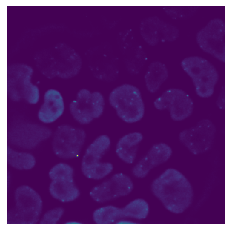

In [19]:
image = images[0]
plt.axis('off')
plt.imshow(image)
plt.savefig('plt.png', bbox_inches='tight', pad_inches = 0)

In [8]:
skimage.io.imsave('skimage.png', image)

Lossy conversion from float32 to uint8. Range [0.0010982645908370614, 59934.953125]. Convert image to uint8 prior to saving to suppress this warning.


In [9]:
np.max(image)

59934.953